# PCA Dimensionality Reduction Lab (ISOLET) — Logistic Regression

This notebook demonstrates **why dimensionality reduction matters** by comparing a **Logistic Regression** classifier trained on:

1. the **original high-dimensional features** (617 features), and  
2. a **PCA-reduced feature space** (k components or variance-retaining PCA).

We evaluate **predictive performance**, **dimensionality-reduction quality**, and **computational cost**.

---

## Student Tasks (5)

**Task 1 — Environment setup (auto-check + auto-install).**  
Verify required Python packages and auto-install any missing dependencies.

**Task 2 — Get the data and explore it.**  
Auto-download the ISOLET dataset files, decompress them, load into pandas, and visualize a small sample.

**Task 3 — Baseline model (Full features).**  
Train **Logistic Regression** on the full 617-dimensional feature set and compute standard classification metrics.

**Task 4 — PCA + model (Reduced features).**  
Train the same Logistic Regression model on PCA-reduced features for multiple PCA settings and benchmark:
- performance metrics (Accuracy, Macro-F1, Balanced Accuracy, Log Loss, ROC-AUC OvR)
- PCA metrics (explained variance, reconstruction error, compression ratio)
- compute cost (fit/predict time, peak Python memory)

**Task 5 — Compare and conclude.**  
Select the best PCA setting (by Macro-F1), compare it against the full-feature baseline, and summarize the trade-offs using tables and plots.


## Task 1 — Setup: check & install dependencies

In [1]:
import sys, importlib, subprocess

# (import_name, pip_name)
REQUIRED = [
    ("numpy", "numpy"),
    ("pandas", "pandas"),
    ("matplotlib", "matplotlib"),
    ("sklearn", "scikit-learn"),
    ("unlzw3", "unlzw3"),   # decompress .Z (LZW)
    ("psutil", "psutil"),   # RSS memory (optional but useful)
]

def ensure_packages(req_list):
    missing = []
    for import_name, pip_name in req_list:
        try:
            importlib.import_module(import_name)
        except Exception:
            missing.append((import_name, pip_name))

    if not missing:
        print("All required packages are already installed ✅")
        return

    print("Missing packages:", [m[1] for m in missing])
    for _, pip_name in missing:
        print(f"Installing: {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pip_name])

    print("Done ✅  (If you still see import errors, restart the kernel and run again.)")

ensure_packages(REQUIRED)


Missing packages: ['unlzw3']
Installing: unlzw3 ...
Done ✅  (If you still see import errors, restart the kernel and run again.)


### Import libraries (after installs)

In [2]:
import os, time, pathlib, urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unlzw3 import unlzw

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, f1_score, balanced_accuracy_score,
    confusion_matrix, ConfusionMatrixDisplay,
    log_loss, roc_auc_score
)

import tracemalloc
import psutil

print("Imports OK ✅")


Imports OK ✅


## Task 2 — Download, decompress, load, and visualize ISOLET

In [3]:
DATA_DIR = pathlib.Path("data_isolet")
DATA_DIR.mkdir(exist_ok=True)

BASE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/isolet/"
FILES = {
    "train_Z": "isolet1+2+3+4.data.Z",  # official training split
    "test_Z": "isolet5.data.Z",         # official test split (requested)
}

def download_if_needed(fname):
    url = BASE_URL + fname
    out_path = DATA_DIR / fname
    if out_path.exists() and out_path.stat().st_size > 0:
        print(f"Already downloaded: {out_path}")
        return out_path

    print(f"Downloading: {url}")
    urllib.request.urlretrieve(url, out_path)
    print(f"Saved to: {out_path} ({out_path.stat().st_size/1e6:.2f} MB)")
    return out_path

train_z = download_if_needed(FILES["train_Z"])
test_z  = download_if_needed(FILES["test_Z"])

(train_z, test_z)


Downloading: https://archive.ics.uci.edu/ml/machine-learning-databases/isolet/isolet1+2+3+4.data.Z
Saved to: data_isolet\isolet1+2+3+4.data.Z (8.07 MB)
Downloading: https://archive.ics.uci.edu/ml/machine-learning-databases/isolet/isolet5.data.Z
Saved to: data_isolet\isolet5.data.Z (2.02 MB)


(WindowsPath('data_isolet/isolet1+2+3+4.data.Z'),
 WindowsPath('data_isolet/isolet5.data.Z'))

In [4]:
def decompress_Z(z_path: pathlib.Path):
    # Decompress a .Z (LZW) file into the same folder, producing a .data file.
    out_path = z_path.with_suffix("")  # strips ".Z"
    if out_path.exists() and out_path.stat().st_size > 0:
        print(f"Already decompressed: {out_path}")
        return out_path

    print(f"Decompressing: {z_path.name} -> {out_path.name}")
    raw = z_path.read_bytes()
    dec = unlzw(raw)
    out_path.write_bytes(dec)
    print(f"Done: {out_path} ({out_path.stat().st_size/1e6:.2f} MB)")
    return out_path

train_path = decompress_Z(train_z)
test_path  = decompress_Z(test_z)

(train_path, test_path)


Decompressing: isolet1+2+3+4.data.Z -> isolet1+2+3+4.data
Done: data_isolet\isolet1+2+3+4.data (32.45 MB)
Decompressing: isolet5.data.Z -> isolet5.data
Done: data_isolet\isolet5.data (8.11 MB)


(WindowsPath('data_isolet/isolet1+2+3+4.data'),
 WindowsPath('data_isolet/isolet5.data'))

In [5]:
def load_isolet(data_path: pathlib.Path):
    # ISOLET: comma-separated, last column is class label (1..26)
    df = pd.read_csv(data_path, header=None)
    X = df.iloc[:, :-1].values.astype(np.float32)
    y = df.iloc[:, -1].values.astype(int)
    return df, X, y

df_train, X_train, y_train = load_isolet(train_path)
df_test,  X_test,  y_test  = load_isolet(test_path)

print("Train shape:", X_train.shape, "Labels:", (y_train.min(), y_train.max()))
print("Test  shape:", X_test.shape,  "Labels:", (y_test.min(), y_test.max()))
df_train.head()


Train shape: (6238, 617) Labels: (1, 26)
Test  shape: (1559, 617) Labels: (1, 26)


,0,1,2,3,4,5,6,7,8,9,...,608,609,610,611,612,613,614,615,616,617
0,-0.4394,-0.0930,0.1718,0.4620,0.6226,0.4704,0.3578,0.0478,-0.1184,-0.2310,...,0.4102,0.2052,0.3846,0.3590,0.5898,0.3334,0.6410,0.5898,-0.4872,1.0
1,-0.4348,-0.1198,0.2474,0.4036,0.5026,0.6328,0.4948,0.0338,-0.0520,-0.1302,...,0.0000,0.2954,0.2046,0.4772,0.0454,0.2046,0.4318,0.4546,-0.0910,1.0
2,-0.2330,0.2124,0.5014,0.5222,-0.3422,-0.5840,-0.7168,-0.6342,-0.8614,-0.8318,...,-0.1112,-0.0476,-0.1746,0.0318,-0.0476,0.1112,0.2540,0.1588,-0.4762,2.0
3,-0.3808,-0.0096,0.2602,0.2554,-0.4290,-0.6746,-0.6868,-0.6650,-0.8410,-0.9614,...,-0.0504,-0.0360,-0.1224,0.1366,0.2950,0.0792,-0.0072,0.0936,-0.1510,2.0
4,-0.3412,0.0946,0.6082,0.6216,-0.1622,-0.3784,-0.4324,-0.4358,-0.4966,-0.5406,...,0.1562,0.3124,0.2500,-0.0938,0.1562,0.3124,0.3124,0.2188,-0.2500,3.0


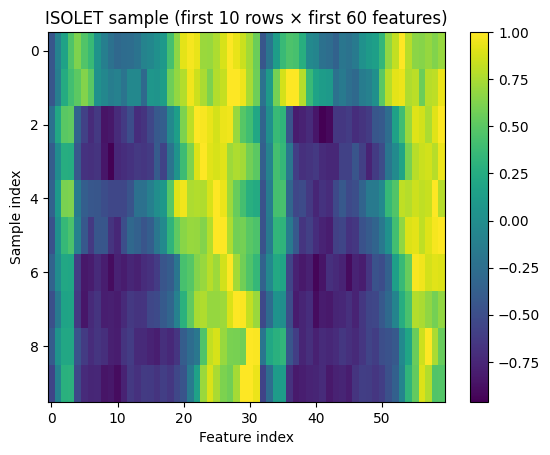

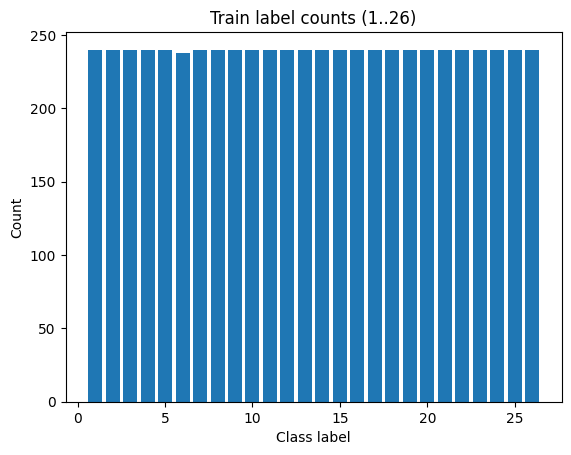

In [6]:
# Plot a small sample as a feature heatmap (10 samples × first 60 features)
n_samples = 10
n_features = 60
sample = X_train[:n_samples, :n_features]

plt.figure()
plt.imshow(sample, aspect="auto")
plt.title("ISOLET sample (first 10 rows × first 60 features)")
plt.xlabel("Feature index")
plt.ylabel("Sample index")
plt.colorbar()
plt.show()

# Label distribution (train)
labels, counts = np.unique(y_train, return_counts=True)
plt.figure()
plt.bar(labels, counts)
plt.title("Train label counts (1..26)")
plt.xlabel("Class label")
plt.ylabel("Count")
plt.show()


## Task 3 — Baseline: Logistic Regression on full 617 features

In [7]:
def timed_fit_predict(pipe, Xtr, ytr, Xte):
    tracemalloc.start()
    t0 = time.perf_counter()
    pipe.fit(Xtr, ytr)
    fit_s = time.perf_counter() - t0
    peak_py_mb = tracemalloc.get_traced_memory()[1] / (1024**2)
    tracemalloc.stop()

    t1 = time.perf_counter()
    yhat = pipe.predict(Xte)
    pred_s = time.perf_counter() - t1

    rss_mb = psutil.Process(os.getpid()).memory_info().rss / (1024**2)
    return yhat, fit_s, pred_s, peak_py_mb, rss_mb

def classification_metrics(y_true, y_pred, y_proba=None):
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "balanced_acc": balanced_accuracy_score(y_true, y_pred),
    }
    if y_proba is not None:
        out["log_loss"] = log_loss(y_true, y_proba)
        try:
            out["roc_auc_ovr_macro"] = roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro")
        except Exception:
            out["roc_auc_ovr_macro"] = np.nan
    return out

baseline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=3000, solver="saga", n_jobs=-1, multi_class="multinomial"
    ))
])

y_pred_full, fit_s_full, pred_s_full, peak_py_mb_full, rss_mb_full = timed_fit_predict(
    baseline, X_train, y_train, X_test
)

proba_full = baseline.predict_proba(X_test)
m_full = classification_metrics(y_test, y_pred_full, proba_full)

m_full, (fit_s_full, pred_s_full, peak_py_mb_full, rss_mb_full)


C:\Users\Dr.PVVK\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


({'accuracy': 0.9576651699807569,
  'macro_f1': 0.957590890745786,
  'balanced_acc': 0.9576162538026943,
  'log_loss': 0.14721791615749177,
  'roc_auc_ovr_macro': 0.9992327928890157},
 (425.39839260000736, 0.011513000004924834, 33.36252784729004, 280.75390625))

<Figure size 640x480 with 0 Axes>

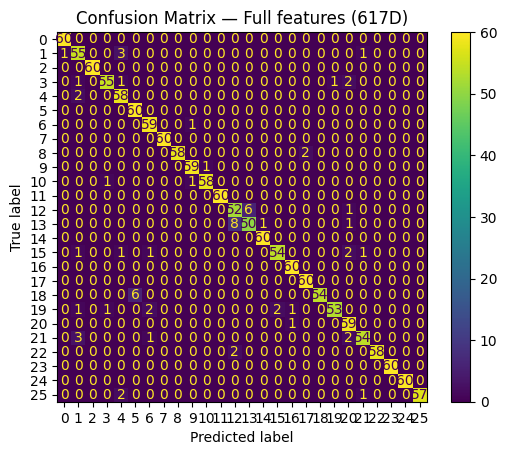

In [8]:
plt.figure()
cm_full = confusion_matrix(y_test, y_pred_full)
disp = ConfusionMatrixDisplay(cm_full)
disp.plot(values_format="d")
plt.title("Confusion Matrix — Full features (617D)")
plt.show()


## Task 4 — PCA + Logistic Regression: sweep PCA settings and benchmark

In [9]:
def pca_recon_mse(scaler, pca, Xtr, n=2000):
    # Reconstruction MSE on a subset (scaled space) for speed
    Xs = scaler.transform(Xtr[:n])
    Z = pca.transform(Xs)
    Xrec = pca.inverse_transform(Z)
    return float(np.mean((Xs - Xrec) ** 2))

def coef_size_bytes(pipe):
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "coef_"):
        b = int(clf.coef_.nbytes)
        if hasattr(clf, "intercept_"):
            b += int(clf.intercept_.nbytes)
        return b
    return np.nan

PCA_SETTINGS = [10, 25, 50, 100, 200, 300, 400, 0.95, 0.99]
rows = []

for setting in PCA_SETTINGS:
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=setting, random_state=42)),
        ("clf", LogisticRegression(
            max_iter=3000, solver="saga", n_jobs=-1, multi_class="multinomial"
        ))
    ])

    y_pred, fit_s, pred_s, peak_py_mb, rss_mb = timed_fit_predict(pipe, X_train, y_train, X_test)
    proba = pipe.predict_proba(X_test)
    mets = classification_metrics(y_test, y_pred, proba)

    pca = pipe.named_steps["pca"]
    scaler = pipe.named_steps["scaler"]

    k_used = int(getattr(pca, "n_components_", np.nan))
    cum_var = float(np.sum(pca.explained_variance_ratio_))
    recon_mse = pca_recon_mse(scaler, pca, X_train)
    comp_ratio = k_used / X_train.shape[1]

    rows.append({
        "pca_setting": setting,
        "k_used": k_used,
        "cum_explained_var": cum_var,
        "recon_mse_scaled": recon_mse,
        "compression_ratio_k_over_d": comp_ratio,
        "fit_s": fit_s,
        "predict_s": pred_s,
        "peak_py_mem_mb": peak_py_mb,
        "rss_mb": rss_mb,
        "model_bytes": coef_size_bytes(pipe),
        **mets
    })

res = pd.DataFrame(rows).sort_values("macro_f1", ascending=False)
res.head(10)


C:\Users\Dr.PVVK\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Dr.PVVK\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Dr.PVVK\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Dr.PVVK\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its defa

,pca_setting,k_used,cum_explained_var,recon_mse_scaled,compression_ratio_k_over_d,fit_s,predict_s,peak_py_mem_mb,rss_mb,model_bytes,accuracy,macro_f1,balanced_acc,log_loss,roc_auc_ovr_macro
5,300.00,300,0.976085,0.024132,0.486224,624.646844,0.013614,33.198378,274.226562,31304,0.958307,0.958238,0.958279,0.153696,0.999161
6,400.00,400,0.989969,0.010294,0.648298,816.303470,0.011268,33.198296,274.246094,41704,0.957665,0.957592,0.957616,0.150574,0.999215
8,0.99,401,0.990068,0.010194,0.649919,808.220170,0.011938,33.198265,273.699219,41808,0.957665,0.957592,0.957616,0.150408,0.999214
4,200.00,200,0.950068,0.049868,0.324149,408.429232,0.010055,33.198393,295.832031,20904,0.953175,0.953043,0.953129,0.170138,0.999059
7,0.95,200,0.950068,0.049868,0.324149,405.737518,0.010039,33.198280,273.464844,20904,0.953175,0.953043,0.953129,0.170123,0.999060
3,100.00,100,0.888993,0.110589,0.162075,206.935293,0.008843,33.198357,295.863281,10504,0.939064,0.938907,0.938961,0.239393,0.998579
2,50.00,50,0.805937,0.193316,0.081037,106.091462,0.009228,33.198423,295.863281,5304,0.932649,0.932369,0.932616,0.222735,0.998596
1,25.00,25,0.706024,0.293815,0.040519,59.163391,0.007915,33.198393,295.808594,2704,0.911482,0.911521,0.911462,0.295858,0.996731
0,10.00,10,0.545737,0.454043,0.016207,14.029223,0.008339,33.203508,295.765625,1144,0.762027,0.760756,0.762038,0.669355,0.988046


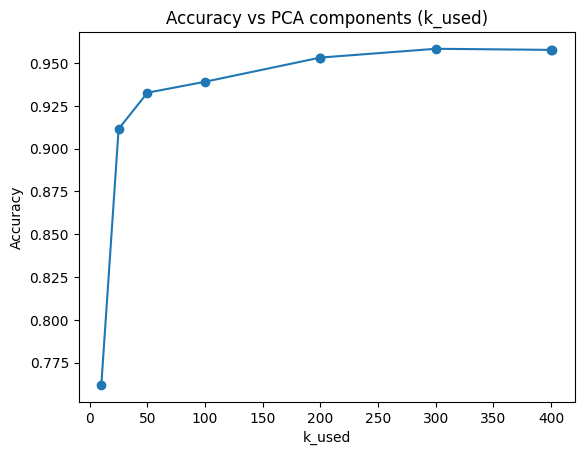

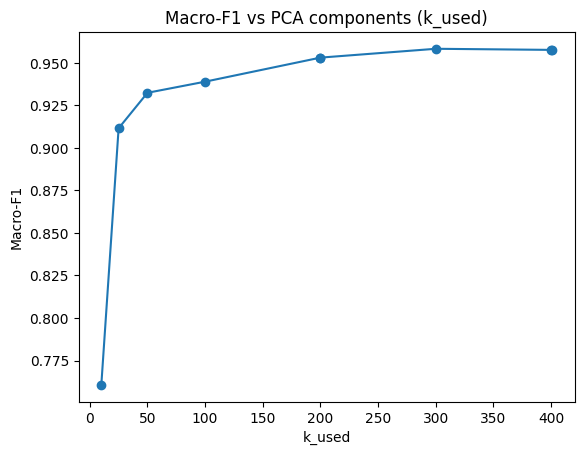

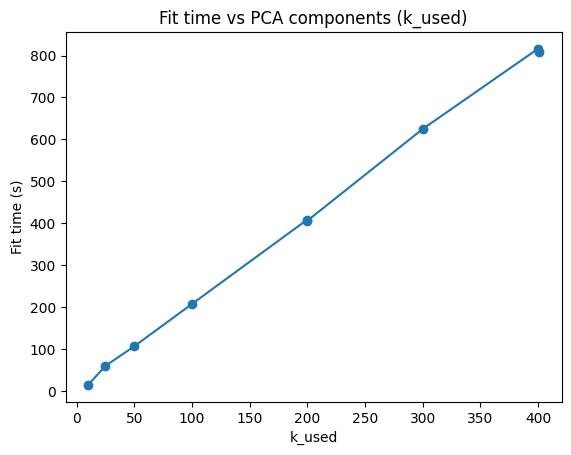

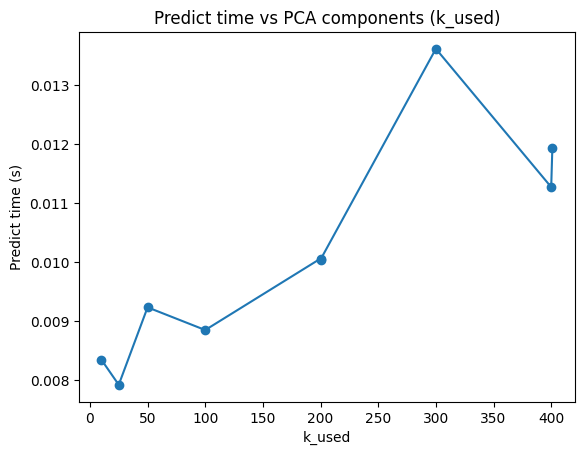

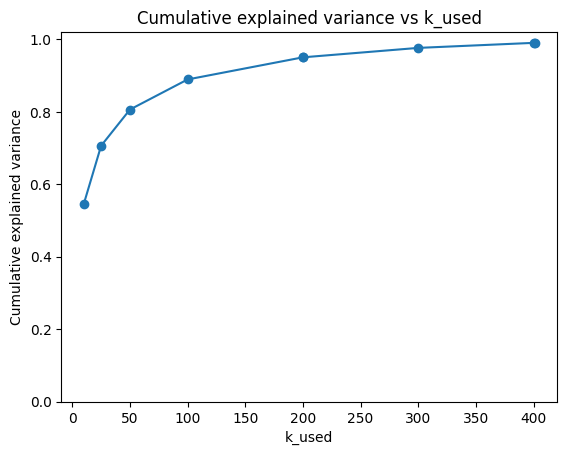

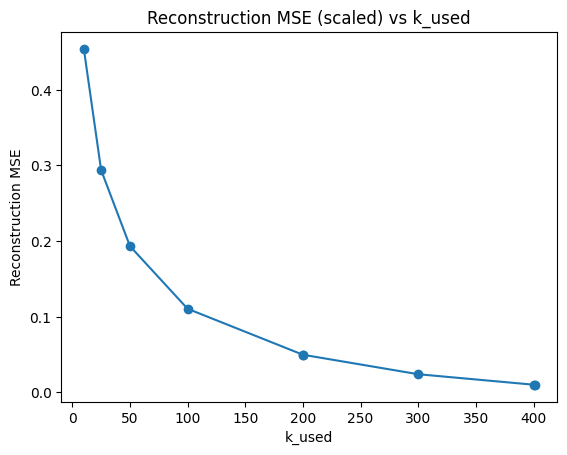

In [10]:
res_sorted = res.sort_values("k_used")

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["accuracy"], marker="o")
plt.title("Accuracy vs PCA components (k_used)")
plt.xlabel("k_used")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["macro_f1"], marker="o")
plt.title("Macro-F1 vs PCA components (k_used)")
plt.xlabel("k_used")
plt.ylabel("Macro-F1")
plt.show()

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["fit_s"], marker="o")
plt.title("Fit time vs PCA components (k_used)")
plt.xlabel("k_used")
plt.ylabel("Fit time (s)")
plt.show()

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["predict_s"], marker="o")
plt.title("Predict time vs PCA components (k_used)")
plt.xlabel("k_used")
plt.ylabel("Predict time (s)")
plt.show()

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["cum_explained_var"], marker="o")
plt.title("Cumulative explained variance vs k_used")
plt.xlabel("k_used")
plt.ylabel("Cumulative explained variance")
plt.ylim(0, 1.02)
plt.show()

plt.figure()
plt.plot(res_sorted["k_used"], res_sorted["recon_mse_scaled"], marker="o")
plt.title("Reconstruction MSE (scaled) vs k_used")
plt.xlabel("k_used")
plt.ylabel("Reconstruction MSE")
plt.show()


## Task 5 — Final comparison: Full-D vs Best PCA

In [11]:
best = res.iloc[0].copy()
best_k = int(best["k_used"])

summary = pd.DataFrame([
    {"model": "LogReg (Full 617D)",
     "k_used": X_train.shape[1],
     "compression_ratio_k_over_d": 1.0,
     **m_full,
     "fit_s": fit_s_full,
     "predict_s": pred_s_full,
     "peak_py_mem_mb": peak_py_mb_full,
     "rss_mb": rss_mb_full
    },
    {"model": f"LogReg + PCA (k={best_k})",
     "k_used": best_k,
     "compression_ratio_k_over_d": best["compression_ratio_k_over_d"],
     "accuracy": best["accuracy"],
     "macro_f1": best["macro_f1"],
     "balanced_acc": best["balanced_acc"],
     "log_loss": best.get("log_loss", np.nan),
     "roc_auc_ovr_macro": best.get("roc_auc_ovr_macro", np.nan),
     "cum_explained_var": best["cum_explained_var"],
     "recon_mse_scaled": best["recon_mse_scaled"],
     "fit_s": best["fit_s"],
     "predict_s": best["predict_s"],
     "peak_py_mem_mb": best["peak_py_mem_mb"],
     "rss_mb": best["rss_mb"]
    }
])

summary


,model,k_used,compression_ratio_k_over_d,accuracy,macro_f1,balanced_acc,log_loss,roc_auc_ovr_macro,fit_s,predict_s,peak_py_mem_mb,rss_mb,cum_explained_var,recon_mse_scaled
0,LogReg (Full 617D),617,1.000000,0.957665,0.957591,0.957616,0.147218,0.999233,425.398393,0.011513,33.362528,280.753906,NaN,NaN
1,LogReg + PCA (k=300),300,0.486224,0.958307,0.958238,0.958279,0.153696,0.999161,624.646844,0.013614,33.198378,274.226562,0.976085,0.024132


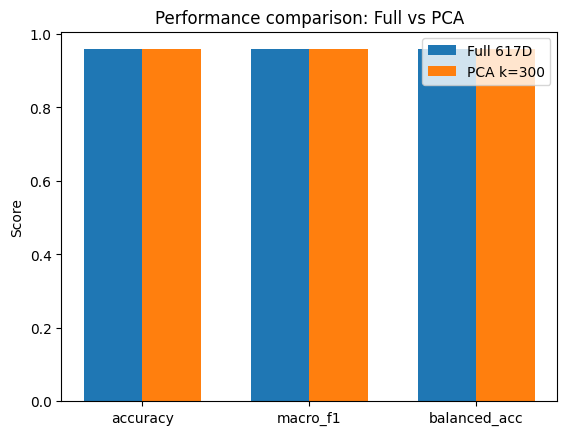

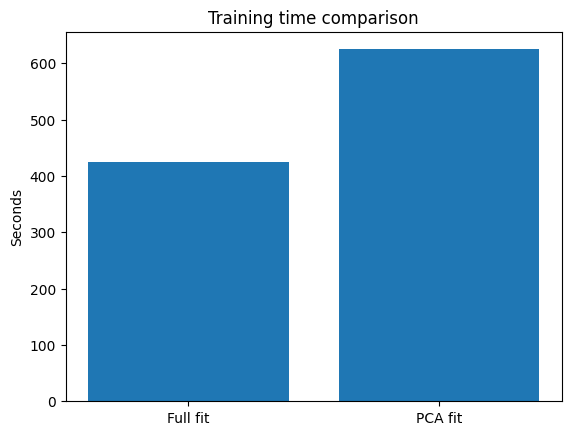

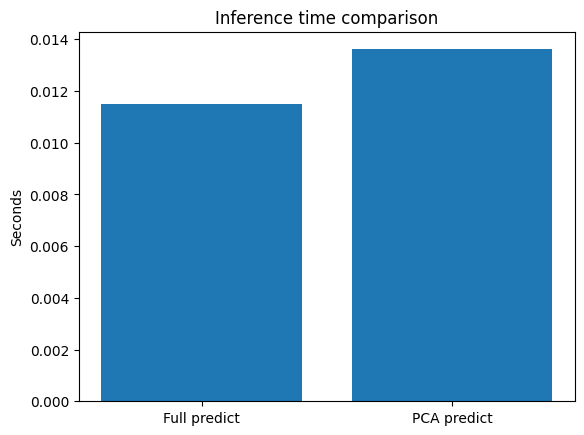

In [12]:
metrics_to_plot = ["accuracy", "macro_f1", "balanced_acc"]
x = np.arange(len(metrics_to_plot))
w = 0.35

full_vals = [summary.loc[0, m] for m in metrics_to_plot]
pca_vals  = [summary.loc[1, m] for m in metrics_to_plot]

plt.figure()
plt.bar(x - w/2, full_vals, width=w, label="Full 617D")
plt.bar(x + w/2, pca_vals,  width=w, label=f"PCA k={int(summary.loc[1,'k_used'])}")
plt.xticks(x, metrics_to_plot)
plt.title("Performance comparison: Full vs PCA")
plt.ylabel("Score")
plt.legend()
plt.show()

plt.figure()
plt.bar(["Full fit", "PCA fit"], [summary.loc[0, "fit_s"], summary.loc[1, "fit_s"]])
plt.title("Training time comparison")
plt.ylabel("Seconds")
plt.show()

plt.figure()
plt.bar(["Full predict", "PCA predict"], [summary.loc[0, "predict_s"], summary.loc[1, "predict_s"]])
plt.title("Inference time comparison")
plt.ylabel("Seconds")
plt.show()


### What to write in your conclusion (student answer)

- Did PCA **hurt/help** Accuracy and Macro‑F1?
- What is the **smallest k** that keeps performance close to the full model?
- How much did **fit time / inference time** change?
- How much **compression** did you get (`k/d`) and how much variance did PCA retain?
- Based on your results, where is the **best trade-off** point?

> Note: `peak_py_mem_mb` is peak *Python-tracked* memory during training (via `tracemalloc`), while `rss_mb` is the process resident memory. Both are useful for relative comparisons, but can vary by OS and environment.
